<a href="https://colab.research.google.com/github/iupui-soic/pybootcamp/blob/main/Rupa_chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of machine learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns machine learning tackles this dataset sooner or later.

# 1. Setup

#### This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
# It also requires Scikit-Learn ≥ 1.0.1:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
# let's define the default font sizes to make the figures prettier:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 2. MNIST

#### The sklearn.datasets package contains mostly three types of functions: fetch_* functions such as fetch_openml() to download real-life datasets, load_* functions to load small toy datasets bundled with Scikit-Learn (so they don’t need to be down‐ loaded over the internet), and make_* functions to generate fake datasets, useful for tests. Generated datasets are usually returned as an (X, y) tuple containing the input data and the targets, both as NumPy arrays. Other datasets are returned as sklearn.utils.Bunch objects, which are dictionaries whose entries can also be accessed as attributes. They generally contain the following entries:
"DESCR"
A description of the dataset
"data"
The input data, usually as a 2D NumPy array
"target"
The labels, usually as a 1D NumPy array

In [ ]:
# here we will use fetch_openml()
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# extra code – it's a bit too long
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [ ]:
# gives a list of all keys
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X.shape

(70000, 784)

In [ ]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [ ]:
y.shape

(70000,)

#### There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset (Figure 3-1). All we need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function. We use cmap="binary" to get a grayscale color map where 0 is white and 255 is black:

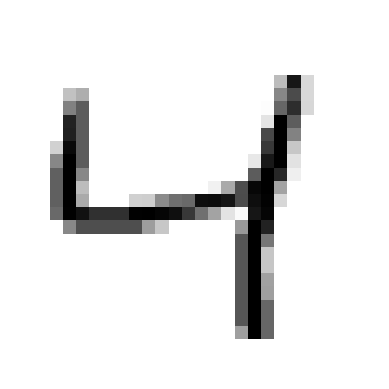

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[2]
plot_digit(some_digit)
plt.show()

In [ ]:
# checking what label says for the image we got
y[2]

'4'

####  You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

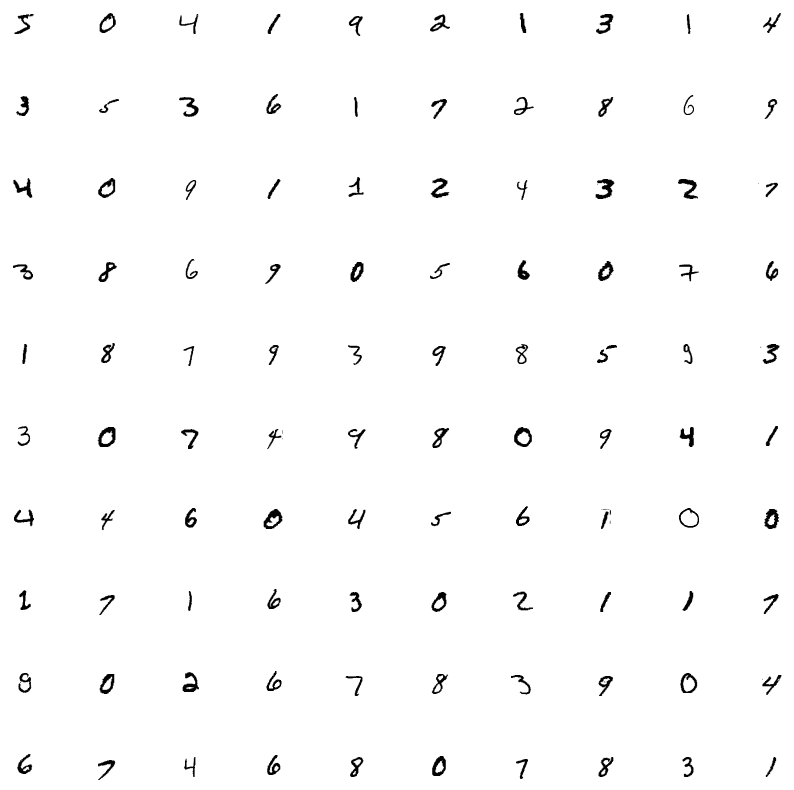

In [ ]:
# extra code – this cell generates Figure 3–2
plt.figure(figsize=(10, 10))
for x, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, x + 1)
    plt.axis("on")
    plot_digit(image_data)
plt.subplots_adjust(wspace=2, hspace=2)
plt.show()

# Training a Binary Classifier


In [ ]:
y_train_4 = (y_train == '4')  # True for all 4s, False for all other digits
y_test_4 = (y_test == '4')

A good place to start is with a stochastic gra‐ dient descent (SGD, or stochastic GD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning, as you will see later. Let’s create an SGDClassifier and train it on the whole training set:


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.9671 , 0.97645, 0.9687 ])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_4):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_4[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_4[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9671
0.97645
0.9687


In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_4)
print(any(dummy_clf.predict(X_train))) # prints False : no 4s detected

False


In [ ]:
cross_val_score(dummy_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.90265, 0.90265, 0.9026 ])

### accuracy is not the best measure for classifiers, especially when dealing with skewed datasets , A much better way to evaluate the performance of a clasiifier is to look at the confusion matrix (CM)

### Confusion Matrices


To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

Just like the cross_val_score() function, cross_val_predict() performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predic‐ tions made on each test fold. This means that you get a clean prediction for each instance in the training set (by “clean” I mean “out-of-sample”: the model makes predictions on data that it never saw during training).

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_4, y_train_pred)
cm

array([[52957,  1201],
       [  554,  5288]])

Each row in a confusion matrix represents an actual class, while each column rep‐ resents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives, also called type II errors), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [ ]:
y_train_perfect_predictions = y_train_4  # pretend we reached perfection
confusion_matrix(y_train_4, y_train_perfect_predictions)

array([[54158,     0],
       [    0,  5842]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier
precision = TP /(TP + FP)
precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier
recall = TP /(TP + FN)



## Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_4, y_train_pred)  # == 5288 / (1201 + 5288)

0.8149175527816305

In [ ]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8149175527816305

In [ ]:
recall_score(y_train_4, y_train_pred)  # == 5288 / (554 + 5288)

0.905169462512838

Now our 4-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 4, it is correct only 81.4% of the time. More‐ over, it only detects 65.1% of the 5s. # in the text book for 5's when recall is caluclated for identifying 4's , it detects 90.5% of the 4's.

It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

Formula for F1 score:

=2× precision×recall / (precision+recall)


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_4, y_train_pred)

0.8576757764982564

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.


## Precision/Recall Trade-off

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3214.66574913])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([ True])

In [ ]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([ True])

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

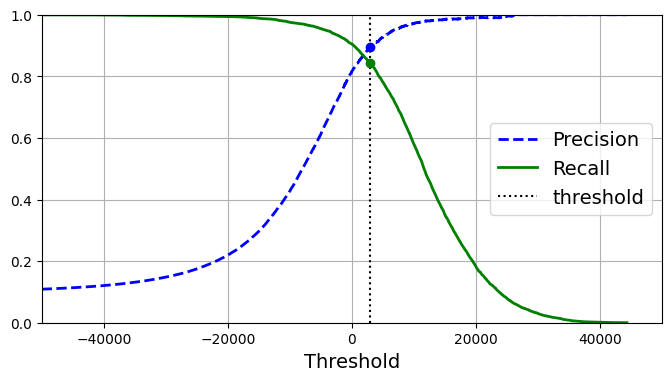

In [ ]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")


plt.show()

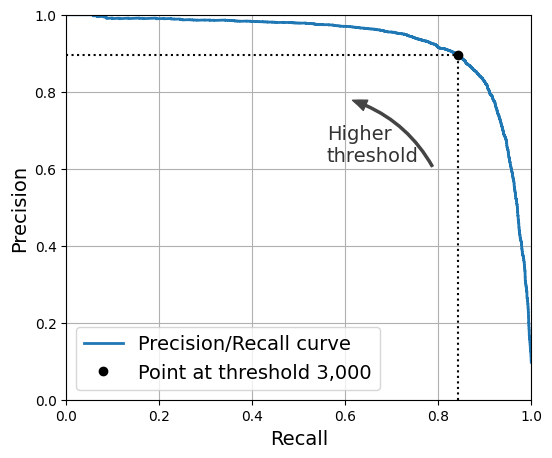

In [ ]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies  Figure
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3196.992969466491

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_4, y_train_pred_90)

0.9001287474710318

In [ ]:
recall_at_90_precision = recall_score(y_train_4, y_train_pred_90)
recall_at_90_precision

0.8377268058883944

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐ ting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

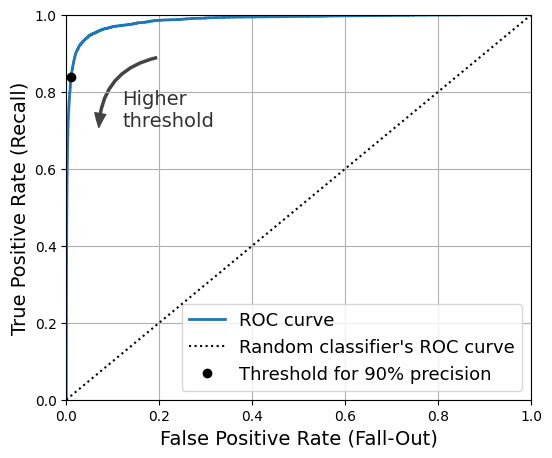

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)


plt.show()

A ROC curve plotting the false positive rate against the true positive rate for all possible thresholds; the black circle highlights the chosen ratio (at 90% precision and 48% recall)


Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC:

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_4, y_scores)

0.9859276923382874

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3,
                                    method="predict_proba")

In [ ]:
y_probas_forest[:2]

array([[1., 0.],
       [1., 0.]])

These are estimated probabilities. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [ ]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_4[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.4%


In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_4, y_scores_forest)

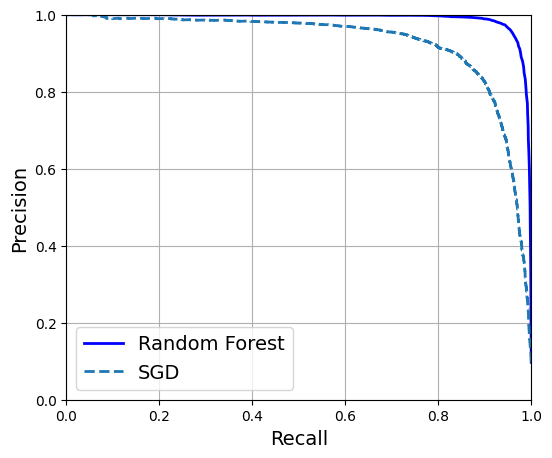

In [ ]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")


plt.show()

Comparing PR curves: the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner, and it has a greater AUC


We could use cross_val_predict(forest_clf, X_train, y_train_5, cv=3) to compute y_train_pred_forest, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_4, y_train_pred_forest)

0.9347452258122907

In [ ]:
roc_auc_score(y_train_4, y_scores_forest)

0.9982278527638186

In [ ]:
precision_score(y_train_4, y_train_pred_forest)

0.9917418859227962

In [ ]:
recall_score(y_train_4, y_train_pred_forest)

0.8839438548442314

Try measuring the precision and recall scores: you should find about 99.1% precision and 88.3% recall. Not too bad!

## Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some Scikit-Learn classifiers (e.g., LogisticRegression, RandomForestClassifier, and GaussianNB) are capable of handling multiple classes natively. Others are strictly binary classifiers (e.g., SGDClassifier and SVC). However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.
One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy, or sometimes one-versus-all (OvA).
Another strategy is to train a binary classifier for every pair of digits: one to distin‐ guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Some algorithms (such as support vector machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

That was easy! We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e., more than 2), Scikit-Learn used the OvO strategy and trained 45 binary classifiers. Now let’s make a prediction on an image:

In [ ]:
svm_clf.predict([some_digit])

array(['4'], dtype=object)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 1.76, -0.29,  7.23,  1.89,  9.3 ,  4.94,  3.84,  6.1 ,  1.75,
         8.19]])

In [ ]:
class_id = some_digit_scores.argmax()
class_id

4

In [ ]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
svm_clf.classes_[class_id]

'4'

If you want decision_function() to return all 45 scores, you can set the decision_function_shape hyperparameter to "ovo". The default value is "ovr", but don't let this confuse you: SVC always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [ ]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.38, -0.65,  0.  , -1.08, -0.17, -0.13, -0.56, -0.02, -0.46,
        -0.9 , -0.84, -1.  , -0.85, -0.77, -0.47, -0.54, -0.69,  0.32,
        -1.  ,  0.35,  0.5 ,  0.04,  0.46, -0.08, -1.  , -0.11, -0.1 ,
        -0.16,  0.52, -0.16,  1.09,  1.04,  1.05,  1.03,  1.41,  0.13,
        -0.27,  0.46, -0.25, -0.18,  0.25, -0.29,  0.21, -0.32, -0.55]])

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [ ]:
ovr_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [ ]:
sgd_clf.decision_function([some_digit]).round()

array([[-34143., -21942.,  -4018.,  -2239.,     43., -15059., -33653.,
         -8278.,  -7461., -14180.]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

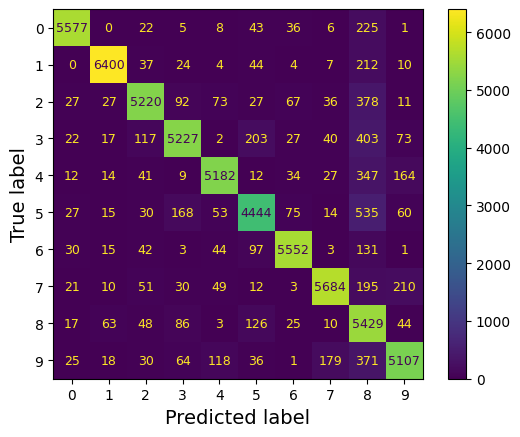

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()


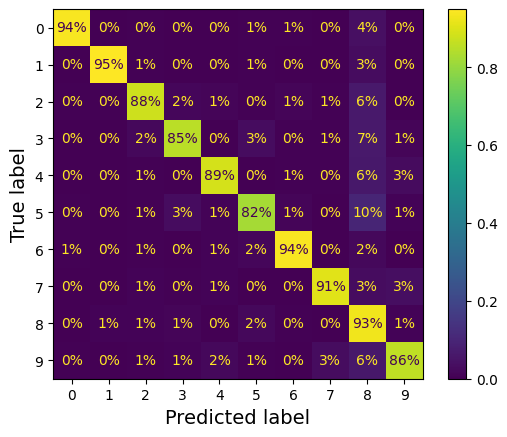

In [ ]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

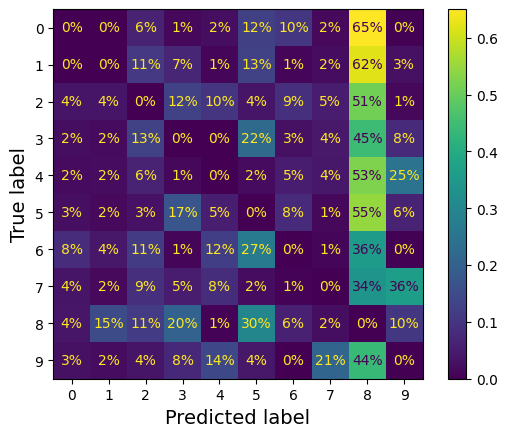

In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

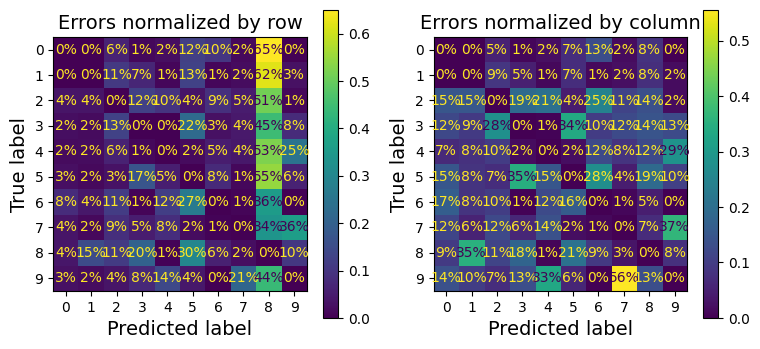

In [ ]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
plt.show()
plt.rc('font', size=14)  # make fonts great again

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

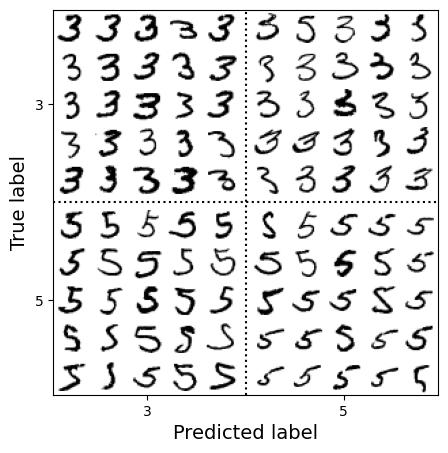

In [ ]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Multilabel Classification

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False, False]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [ ]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [ ]:
chain_clf.predict([some_digit])

array([[0., 0.]])

## Multioutput Classification

In [ ]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

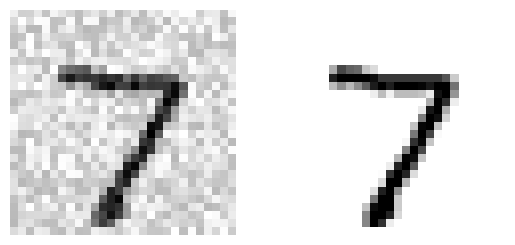

In [ ]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

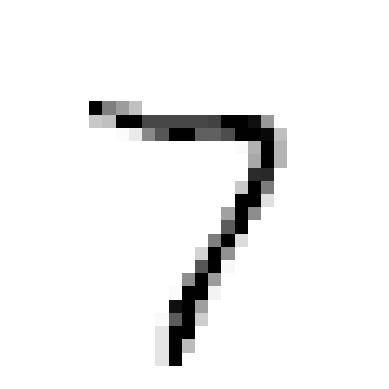

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()